In [1]:
import sys
sys.path.append('../experiments')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils
import joblib
import pandas as pd
# from run_experiment import run_experiment
# import pmsurv_exponential 
import pmsurv_weibull
# import pmsurv_weibull_nn
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
# from pmsurv.models.exponential_model import ExponentialModel
from pmsurv.models.weibull_linear import WeibullModelLinear
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmsurv

In [4]:
SEED = 42

In [84]:
dataset, config = utils.load_data('../experiments/data/veteran')
train_kwargs = {'jobs': 5, 'n_iter': 10}


In [85]:
dataset['celltype_1:trt'] = dataset['celltype_1'] * dataset['trt_2']
dataset['celltype_2:trt'] = dataset['celltype_2'] * dataset['trt_2']
dataset['celltype_3:trt'] = dataset['celltype_3'] * dataset['trt_2']
dataset['celltype_4:trt'] = dataset['celltype_4'] * dataset['trt_2']

config['features'] = ['age', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
config['preprocessing']['standardize'] = True
config['preprocessing']['continuous_features'] = ['age']
continuous_features = config['preprocessing']['continuous_features']

In [86]:
dataset[config['features']]

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
132,65,1.0,0.0,0.0,1.0,0.0,0.0,1.0
133,64,1.0,0.0,0.0,1.0,0.0,0.0,1.0
134,67,1.0,0.0,0.0,1.0,0.0,0.0,1.0
135,65,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [93]:
X_predict_original = pd.DataFrame({
    'age': [50, 50, 65, 65],
    'trt_2': [0, 0, 1, 0],
    'celltype_2': [0, 0, 1, 1], 
    'celltype_3': [1, 1, 0, 0], 
    'celltype_4': [0, 0, 0, 0], 
    'celltype_2:trt': [0, 0, 1, 0], 
    'celltype_3:trt': [1, 0, 0, 0],  
    'celltype_4:trt': [0, 0, 0, 0],
})
X_predict_original

,age,trt_2,celltype_2,celltype_3,celltype_4,celltype_2:trt,celltype_3:trt,celltype_4:trt
0,50,0,0,1,0,0,1,0
1,50,0,0,1,0,0,0,0
2,65,1,1,0,0,1,0,0
3,65,0,1,0,0,0,0,0


In [88]:
def train_model_generic(dataset, config, train_kwargs, preprocess_data_fun, train_fun):
    dataset = dataset.dropna(subset=config['features'])
    X, y = preprocess_data_fun(dataset, config)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=config['split']['test_size'],
                                                        shuffle=config['split']['shuffle'])

    if config['preprocessing']['standardize']:
        X_train, X_test, scaler = utils.standardize(X_train, X_test, config)
    else:
        scaler = None

    pipeline, parameters, fit_params = train_fun(X_train, y_train, config, train_kwargs)
    n_cv = 5
    n_points = int(train_kwargs['jobs'] / n_cv)
    opt = BayesSearchCV(pipeline, parameters,
                        fit_params=fit_params,
                        n_jobs=train_kwargs['jobs'],
                        n_points=n_points if n_points > 1 else 1,
                        n_iter=train_kwargs['n_iter'],
                        cv=n_cv,
                        error_score='raise')
    opt.fit(X_train, y_train)
    metrics = opt.best_estimator_.score(X_test, y_test)
    print("Test metrics: " + str(metrics))

    return metrics, opt.best_estimator_, opt.best_params_, scaler, (X_train, X_test, y_train, y_test)

# Train

In [89]:
import pmsurv_weibull

In [91]:
metrics, model_wb, best_params_wb, scaler_wb, _ = train_model_generic(dataset, config, train_kwargs, pmsurv_weibull.preprocess_data, pmsurv_weibull.train_model)

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10

Compiling...
Compilation time =  0:00:02.060497
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]WARNING:jax._src.lib.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compiling...
Compilation time =  0:00:02.401927
Sampling...
Compiling...
Compilation time =  0:00:02.558473
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Compiling...
Compilation time =  0:00:02.743026
Sampling...
Compiling...
Compilation time =  0:00:02.748475
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 249.01it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 252.82it/s] 

Running chain 1:  65%|██████▌   | 1950/3000 [00:12<00:00, 5378.02it/s]/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 233.74it/s] 
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling

Sampling time =  0:00:14.051143
Transforming variables...
Transformation time =  0:00:00.722412
Computing Log Likelihood...
Log Likelihood time =  0:00:01.399387
fitted
Compiling...
Compilation time =  0:00:04.512519
Sampling...
Sampling time =  0:00:13.236075
Transforming variables...
Transformation time =  0:00:00.539767
Computing Log Likelihood...
Log Likelihood time =  0:00:01.728710
fitted
Compiling...
Compilation time =  0:00:04.714136
Sampling...
Sampling time =  0:00:13.073752
Transforming variables...
Transformation time =  0:00:00.749977
Computing Log Likelihood...
Log Likelihood time =  0:00:01.668217
fitted
Compiling...
Compilation time =  0:00:04.606656
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:12.901215
Transforming variables...
Transformation time =  0:00:00.641448
Computing Log Likelihood...
Log Likelihood time =  0:00:01.618275
fitted
Compiling...
Compilation time =  0:00:05.202516
Sampling...
Sampling time =  0:00:14.056462
Transforming variables...
Transformation time =  0:00:00.508823
Computing Log Likelihood...
Log Likelihood time =  0:00:01.461434
fitted
Compiling...
Compilation time =  0:00:04.814163
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 231.63it/s] 

Running chain 0:  15%|█▌        | 450/3000 [00:13<00:01, 2110.84it/s]]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 226.92it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 229.22it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 218.00it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self

Sampling time =  0:00:13.575184
Transforming variables...
Transformation time =  0:00:00.696643
Computing Log Likelihood...
Log Likelihood time =  0:00:01.382761
fitted
Compiling...
Compilation time =  0:00:02.041772
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.857200
Transforming variables...
Transformation time =  0:00:00.592452
Computing Log Likelihood...
Log Likelihood time =  0:00:01.089300
fitted
Compiling...
Compilation time =  0:00:02.564616
Sampling...
Sampling time =  0:00:14.032501
Transforming variables...
Transformation time =  0:00:00.719483
Computing Log Likelihood...
Log Likelihood time =  0:00:01.649002
fitted
Compiling...
Compilation time =  0:00:02.436861
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.578806
Transforming variables...
Transformation time =  0:00:00.746452
Computing Log Likelihood...
Log Likelihood time =  0:00:01.325202
fitted
Compiling...
Compilation time =  0:00:02.513056
Sampling...
Sampling time =  0:00:13.711866
Transforming variables...
Transformation time =  0:00:00.811414
Computing Log Likelihood...
Log Likelihood time =  0:00:01.438868
fitted
Compiling...
Compilation time =  0:00:02.513034
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 299.42it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 295.41it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 292.57it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Sampling time =  0:00:10.329766
Transforming variables...
Transformation time =  0:00:00.406847
Computing Log Likelihood...
Log Likelihood time =  0:00:01.225712
fitted
Compiling...
Compilation time =  0:00:03.817072
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.223944
Transforming variables...
Transformation time =  0:00:00.326219
Computing Log Likelihood...
Log Likelihood time =  0:00:00.961762
fitted
Compiling...
Compilation time =  0:00:04.064612
Sampling...
Sampling time =  0:00:10.930943
Transforming variables...
Transformation time =  0:00:00.309277
Computing Log Likelihood...
Log Likelihood time =  0:00:00.511283
fitted
Compiling...
Compilation time =  0:00:04.284356
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.732105
Transforming variables...
Transformation time =  0:00:00.401253
Computing Log Likelihood...
Log Likelihood time =  0:00:00.587327
fitted
Compiling...
Compilation time =  0:00:04.482082
Sampling...
Sampling time =  0:00:10.371997
Transforming variables...
Transformation time =  0:00:00.406157
Computing Log Likelihood...
Log Likelihood time =  0:00:00.601438
fitted
Compiling...
Compilation time =  0:00:04.392536
Sampling...


Running chain 0:  10%|█         | 300/3000 [00:12<00:02, 1038.57it/s]

Running chain 1:  25%|██▌       | 750/3000 [00:12<00:01, 1667.84it/s]

Running chain 0:  65%|██████▌   | 1950/3000 [00:13<00:00, 1930.05it/s][A

Running chain 0:  30%|███       | 900/3000 [00:12<00:01, 1689.38it/s]

Running chain 1:  40%|████      | 1200/3000 [00:13<00:01, 1696.48it/s]

Running chain 0:  80%|████████  | 2400/3000 [00:14<00:00, 1648.25it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 213.39it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 210.41it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parame

Sampling time =  0:00:14.997041
Transforming variables...
Transformation time =  0:00:00.578291
Computing Log Likelihood...
Log Likelihood time =  0:00:01.251047
fitted
Compiling...
Compilation time =  0:00:03.662033
Sampling...
Sampling time =  0:00:14.201629
Transforming variables...
Transformation time =  0:00:00.643459
Computing Log Likelihood...
Log Likelihood time =  0:00:01.019129
fitted
Compiling...
Compilation time =  0:00:03.773136
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.729663
Transforming variables...
Transformation time =  0:00:00.624391
Computing Log Likelihood...
Log Likelihood time =  0:00:01.031652
fitted
Compiling...
Compilation time =  0:00:04.044090
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:14.555080
Transforming variables...
Transformation time =  0:00:00.694431
Computing Log Likelihood...
Log Likelihood time =  0:00:01.134205
fitted
Compiling...
Compilation time =  0:00:03.991229
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.225576
Transforming variables...
Transformation time =  0:00:00.836226
Computing Log Likelihood...
Log Likelihood time =  0:00:00.708328
fitted
Compiling...
Compilation time =  0:00:04.500224
Sampling...


Running chain 1:  40%|████      | 1200/3000 [00:14<00:00, 1974.90it/s]

Running chain 0:  10%|█         | 300/3000 [00:15<00:02, 987.72it/s] 

Running chain 0:  70%|███████   | 2100/3000 [00:15<00:00, 1804.70it/s][A

Running chain 1: 100%|██████████| 3000/3000 [00:16<00:00, 185.34it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:17<00:00, 170.86it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=sel

Sampling time =  0:00:17.104805
Transforming variables...
Transformation time =  0:00:00.910769
Computing Log Likelihood...
Log Likelihood time =  0:00:00.787495
fitted
Compiling...
Compilation time =  0:00:02.997202
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:16.848226
Transforming variables...
Transformation time =  0:00:01.050146
Computing Log Likelihood...
Log Likelihood time =  0:00:01.105490
fitted
Compiling...
Compilation time =  0:00:03.344570
Sampling...
Sampling time =  0:00:18.104529
Transforming variables...
Transformation time =  0:00:00.670443
Computing Log Likelihood...
Log Likelihood time =  0:00:01.136599
fitted
Compiling...
Compilation time =  0:00:03.337491
Sampling...
Sampling time =  0:00:17.522962
Transforming variables...
Transformation time =  0:00:00.688673
Computing Log Likelihood...
Log Likelihood time =  0:00:01.005914
fitted
Compiling...
Compilation time =  0:00:03.519081
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:17.316047
Transforming variables...
Transformation time =  0:00:00.671745
Computing Log Likelihood...
Log Likelihood time =  0:00:00.928150
fitted
Compiling...
Compilation time =  0:00:03.451387
Sampling...


Running chain 0:  75%|███████▌  | 2250/3000 [00:10<00:00, 3326.54it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 267.05it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 261.21it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Sampling time =  0:00:11.247067
Transforming variables...
Transformation time =  0:00:00.396690
Computing Log Likelihood...
Log Likelihood time =  0:00:01.230151
fitted
Compiling...
Compilation time =  0:00:02.275608
Sampling...
Sampling time =  0:00:11.879574
Transforming variables...
Transformation time =  0:00:00.322704
Computing Log Likelihood...
Log Likelihood time =  0:00:00.686297
fitted
Compiling...
Compilation time =  0:00:02.176897
Sampling...
Sampling time =  0:00:11.882033
Transforming variables...
Transformation time =  0:00:00.284311
Computing Log Likelihood...
Log Likelihood time =  0:00:00.614245
fitted
Compiling...
Compilation time =  0:00:02.471202
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:11.651477
Transforming variables...
Transformation time =  0:00:00.335600
Computing Log Likelihood...
Log Likelihood time =  0:00:00.893439
fitted
Compiling...
Compilation time =  0:00:02.423208
Sampling...
Sampling time =  0:00:11.173824
Transforming variables...
Transformation time =  0:00:00.441011
Computing Log Likelihood...
Log Likelihood time =  0:00:00.995843
fitted
Compiling...
Compilation time =  0:00:02.446323
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 315.80it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:09<00:00, 300.43it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:10<00:00, 282.42it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Sampling time =  0:00:10.708555
Transforming variables...
Transformation time =  0:00:00.586144
Computing Log Likelihood...
Log Likelihood time =  0:00:01.019834
fitted
Compiling...
Compilation time =  0:00:04.355392
Sampling...
Sampling time =  0:00:11.016724
Transforming variables...
Transformation time =  0:00:00.311544
Computing Log Likelihood...
Log Likelihood time =  0:00:00.865921
fitted
Compiling...
Compilation time =  0:00:04.575666
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:10.581167
Transforming variables...
Transformation time =  0:00:00.464160
Computing Log Likelihood...
Log Likelihood time =  0:00:00.759645
fitted
Compiling...
Compilation time =  0:00:04.299453
Sampling...
Sampling time =  0:00:10.733796
Transforming variables...
Transformation time =  0:00:00.294677
Computing Log Likelihood...
Log Likelihood time =  0:00:00.661829
fitted
Compiling...
Compilation time =  0:00:04.678651
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:09.940614
Transforming variables...
Transformation time =  0:00:00.484026
Computing Log Likelihood...
Log Likelihood time =  0:00:00.607067
fitted
Compiling...
Compilation time =  0:00:04.657331
Sampling...


Running chain 0:   0%|          | 0/3000 [00:14<?, ?it/s]1646.40it/s]]A

Running chain 0:  30%|███       | 900/3000 [00:13<00:01, 1677.39it/s]

Running chain 0:  20%|██        | 600/3000 [00:14<00:01, 1492.74it/s]]


Running chain 1: 100%|██████████| 3000/3000 [00:14<00:00, 203.52it/s] 

Running chain 1:  60%|██████    | 1800/3000 [00:15<00:00, 2436.13it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:15<00:00, 196.83it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:15<00:00, 190.61it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely t

Sampling time =  0:00:15.948739
Transforming variables...
Transformation time =  0:00:00.555374
Computing Log Likelihood...
Log Likelihood time =  0:00:00.920218
fitted
Compiling...
Compilation time =  0:00:02.794772
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:16.177162
Transforming variables...
Transformation time =  0:00:00.640263
Computing Log Likelihood...
Log Likelihood time =  0:00:00.738486
fitted
Compiling...
Compilation time =  0:00:02.911782
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:16.189628
Transforming variables...
Transformation time =  0:00:00.513851
Computing Log Likelihood...
Log Likelihood time =  0:00:00.696533
fitted
Compiling...
Compilation time =  0:00:03.279814
Sampling...
Sampling time =  0:00:15.553764
Transforming variables...
Transformation time =  0:00:00.713723
Computing Log Likelihood...
Log Likelihood time =  0:00:00.904090
fitted
Compiling...
Compilation time =  0:00:03.230507
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.513863
Transforming variables...
Transformation time =  0:00:00.820497
Computing Log Likelihood...
Log Likelihood time =  0:00:00.893165
fitted
Compiling...
Compilation time =  0:00:03.450825
Sampling...


Running chain 0:  65%|██████▌   | 1950/3000 [00:12<00:00, 3228.28it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 225.73it/s] 

Running chain 0:  65%|██████▌   | 1950/3000 [00:13<00:00, 3583.93it/s]

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 219.63it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 214.93it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self

Sampling time =  0:00:14.255714
Transforming variables...
Transformation time =  0:00:00.500896
Computing Log Likelihood...
Log Likelihood time =  0:00:00.684381
fitted
Compiling...
Compilation time =  0:00:02.968748
Sampling...
Sampling time =  0:00:14.180803
Transforming variables...
Transformation time =  0:00:00.690883
Computing Log Likelihood...
Log Likelihood time =  0:00:01.034241
fitted
Compiling...
Compilation time =  0:00:03.068187
Sampling...
Sampling time =  0:00:13.764260
Transforming variables...
Transformation time =  0:00:00.553030
Computing Log Likelihood...
Log Likelihood time =  0:00:00.612747
fitted
Compiling...
Compilation time =  0:00:03.244260
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:13.242668
Transforming variables...
Transformation time =  0:00:00.685382
Computing Log Likelihood...
Log Likelihood time =  0:00:01.022649
fitted
Compiling...
Compilation time =  0:00:03.734147
Sampling...
Sampling time =  0:00:14.481929
Transforming variables...
Transformation time =  0:00:00.447909
Computing Log Likelihood...
Log Likelihood time =  0:00:00.662855
fitted
Compiling...
Compilation time =  0:00:03.171356
Sampling...


Running chain 1: 100%|██████████| 3000/3000 [00:12<00:00, 244.64it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:11<00:00, 253.27it/s] 

Running chain 1: 100%|██████████| 3000/3000 [00:13<00:00, 226.60it/s] 
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []
Sampling: []
INFO:pymc:Sampling: []
/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The

Compiling...
Compilation time =  0:00:02.401220
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:06.139847
Transforming variables...
Transformation time =  0:00:00.281452
Computing Log Likelihood...


/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []


Log Likelihood time =  0:00:00.785304
fitted
Test metrics: 0.5607734806629834


In [94]:
X_predict = X_predict_original.copy()
X_predict[continuous_features] = scaler_wb.transform(X_predict[continuous_features])
surv_wb, surv_wb_lower, surv_wb_upper = model_wb.predict(X_predict)
t_plot_wb = pmsurv.utils.get_time_axis(0, model_wb['model'].max_time, 10) / 30.25

/home/pymc/src/pmsurv/models/weibull_base.py:69: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, model=self.cached_model, return_inferencedata=False,
Sampling: []
INFO:pymc:Sampling: []


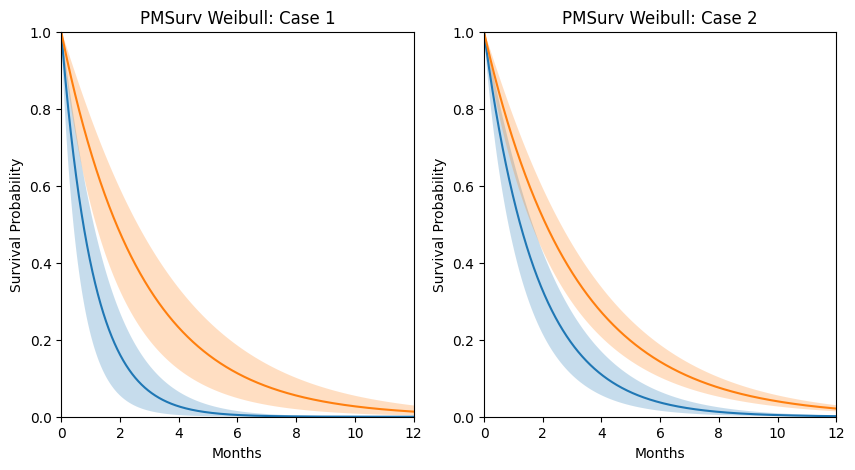

In [95]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("PMSurv Weibull: Case 1");
plt.plot(t_plot_wb, surv_wb[0]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[0], y2=surv_wb_upper[0], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[1]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[1], y2=surv_wb_upper[1], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

plt.subplot(1, 2, 2)
plt.title("PMSurv Weibull: Case 2");
plt.plot(t_plot_wb, surv_wb[2]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[2], y2=surv_wb_upper[2], alpha=0.25);
plt.plot(t_plot_wb, surv_wb[3]);
plt.fill_between(t_plot_wb, y1=surv_wb_lower[3], y2=surv_wb_upper[3], alpha=0.25);
plt.ylim(0, 1);
plt.xlim(0, 12);
plt.ylabel("Survival Probability");
plt.xlabel("Months");

In [127]:
import numpy as np

490

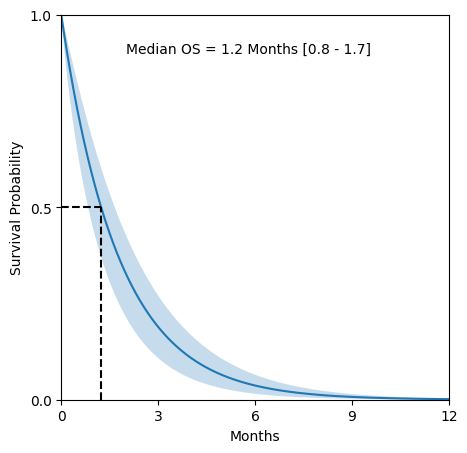

In [180]:
idx = 2
surv = surv_wb[idx]
surv_lower = surv_wb_lower[idx]
surv_upper = surv_wb_upper[idx]
              
median_os = t_plot_wb[np.argmax(surv < 0.5)]
median_os_lower = t_plot_wb[np.argmax(surv_lower < 0.5)]
median_os_upper = t_plot_wb[np.argmax(surv_upper < 0.5)]

plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t_plot_wb, y=surv)
plt.fill_between(t_plot_wb, y1=surv_lower, y2=surv_upper, alpha=0.25);
plt.hlines(y=0.5, xmin=0, xmax=median_os, colors='black', linestyles='dashed')
plt.vlines(x=median_os, ymin=0, ymax=0.5, colors='black', linestyles='dashed')
plt.text(x=2, y=0.9, s=f"Median OS = {median_os:0.1f} Months [{median_os_lower:0.1f} - {median_os_upper:0.1f}]")
plt.ylim(0, 1);
plt.xlim(0, 12);
ax.set(xticks=[0, 3, 6, 9, 12], yticks=[0, 0.5, 1], ylabel='Survival Probability', xlabel='Months');


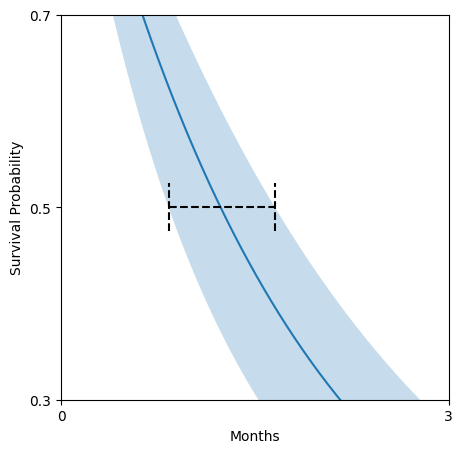

In [178]:
plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t_plot_wb, y=surv)
plt.fill_between(t_plot_wb, y1=surv_lower, y2=surv_upper, alpha=0.25);
plt.hlines(y=0.5, xmin=median_os_lower, xmax=median_os_upper, colors='black', linestyles='dashed')
plt.vlines(x=median_os_lower, ymin=0.475, ymax=0.525, colors='black', linestyles='dashed')
plt.vlines(x=median_os_upper, ymin=0.475, ymax=0.525, colors='black', linestyles='dashed')

# plt.text(x=3, y=0.75, s=f"Median OS = {median_os:0.1f} Months [{median_os_lower:0.1f} - {median_os_upper:0.1f}]")
plt.ylim(0.3, 0.7);
plt.xlim(1, 3);
ax.set(xticks=[0, 3], yticks=[0.3, 0.5, 0.7], ylabel='Survival Probability', xlabel='Months');

In [96]:
import arviz as az

In [97]:
import seaborn as sns

array(['trt_2', 'celltype_2', 'celltype_3', 'celltype_4',
       'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt'], dtype=object)

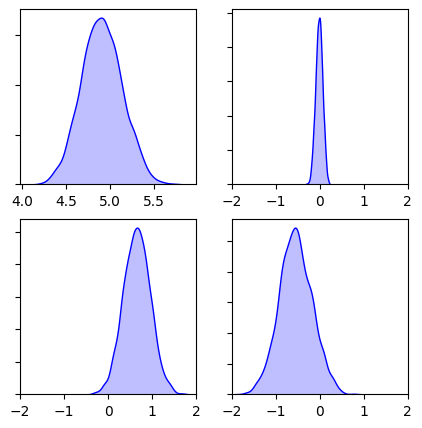

In [216]:
xlimits = [-2, 2]
plt.figure(figsize=(5, 5))
plt.subplot(2, 2, 1)
posterior = model_wb['model'].trace.posterior['lambda_intercept'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# plt.xlim(xlimits)
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');


plt.subplot(2, 2, 2)
posterior = model_wb['model'].trace.posterior['k_intercept'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');

plt.xlim(xlimits)

plt.subplot(2, 2, 3)
posterior = model_wb['model'].trace.posterior['lambda_column_0'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');
plt.xlim(xlimits)

plt.subplot(2, 2, 4)
posterior = model_wb['model'].trace.posterior['lambda_column_2'].values.flatten()
ax = sns.kdeplot(posterior, color='blue', fill=True);
# ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], ylabel='');
ax.set(yticklabels=[], ylabel='');
plt.xlim(xlimits);


In [238]:
model_wb['model'].trace.posterior.keys()


KeysView(<xarray.Dataset>
Dimensions:           (chain: 2, draw: 2000, lambda_det_dim_0: 109,
                       k_det_dim_0: 109)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * lambda_det_dim_0  (lambda_det_dim_0) int64 0 1 2 3 4 ... 104 105 106 107 108
  * k_det_dim_0       (k_det_dim_0) int64 0 1 2 3 4 5 ... 104 105 106 107 108
Data variables:
    lambda_intercept  (chain, draw) float64 4.842 4.913 4.907 ... 5.338 5.068
    k_intercept       (chain, draw) float64 0.05547 -0.07436 ... -0.09134
    lambda_column_0   (chain, draw) float64 0.9155 0.1929 ... 0.1019 0.5605
    lambda_column_1   (chain, draw) float64 -0.01704 -0.3339 ... -0.6112 -0.9756
    lambda_column_2   (chain, draw) float64 -0.3296 -0.6052 ... -0.7646 -0.5443
    lambda_column_3   (chain, draw) float64 0.6056 0.5788 ... -0.2183 -0.09891
    lambda_column_4   (chain, draw) float64 -2.029 -1.013 ... -0.8125 -0.7628
    lambda

In [260]:
cols = ['lambda_intercept', 'trt_2', 'celltype_2', 'celltype_3', 'celltype_4', 'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt']
cols_post = ['lambda_intercept',  'lambda_column_0', 'lambda_column_1', 'lambda_column_2', 'lambda_column_3', 'lambda_column_4', 'lambda_column_5', 'lambda_column_6']


In [261]:
df_posteriors = pd.DataFrame({
    'column': np.repeat(cols, 4000),
    'samples': np.concatenate([model_wb['model'].trace.posterior[c].values.flatten() for c in cols_post])
})

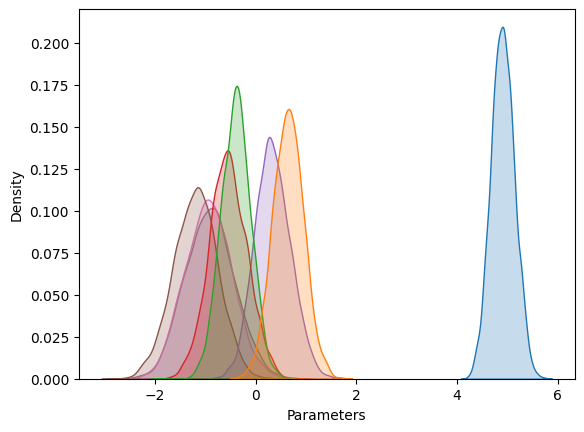

In [262]:
ax = sns.kdeplot(data = df_posteriors, x = 'samples', hue='column', fill=True, legend=None);
ax.set(xlabel='Parameters');

In [182]:
import pymc as pm

In [187]:
with pm.Model() as model:
    lambda_intercept = pm.Normal("λ_intercept", mu=0, sigma=1)
    k_intercept = pm.Normal("κ_intercept", mu=0, sigma=1)
    
    lambda_1 = pm.Normal("λ_age", mu=0, sigma=1)
    lambda_2 = pm.Normal("λ_trt", mu=0, sigma=1)
    lambda_3 = pm.Normal("λ_celltype", mu=0, sigma=1)
    
    lambda_det = pm.Deterministic('λ', pm.math.exp(lambda_intercept + lambda_1 + lambda_2 + lambda_3))
    k_det = pm.Deterministic('κ', pm.math.exp(k_intercept))
    
    y = pm.Weibull('y', alpha=k_det, beta=lambda_det)
    

array(['trt_2', 'celltype_2', 'celltype_3', 'celltype_4',
       'celltype_2:trt', 'celltype_3:trt', 'celltype_4:trt'], dtype=object)